<a href="https://colab.research.google.com/github/jbinteam/010723305/blob/main/my_face_emotional_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'face-emotion:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F902987%2F1531489%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240801%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240801T120709Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daf9700bceb317cbecb5e2a36a7130cf05c89c12669eb73579e9d0156c0d6420c58407552f4d61265ff0e9a6cf7f798ea37552eec6511da2a9833c3a0b36ece0ce15d67289ee3ebdd4b9b5386f99e441f05d91e2ba347ea440f720696a2de08c6937bf1e6b730f06c1e5bc8b01a1f515a9b8f36f7e5030e4cff9b285f88f5c7a60e0afc0af1da1ca968e111d246f97cd9d938ded430c54d928f4c6edf084f2f09b867c76cb976a0a62f1b4edea349c3259e1e6a0060e2e6cba7da6cdb5c3d4b4422faeb58c64f466f9be7ca8b8c5fb36c46276667f05a08992cc8315a0265668ea67db2dcc79ccdbe3ee50aca26f6595cfab6280a11b721810fb252d58d7ade20'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import os

from matplotlib import pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.list_data=[]
        self.classes=None
        for dirname, _, filenames in os.walk(root):
            if self.classes==None:
                self.classes=_
            for filename in filenames:
                class_name=dirname.split('/')
                self.list_data.append([self.classes.index(class_name[6]),os.path.join(dirname,filename)])
        self.transform = transform
        self.target_transform = target_transform
        self.nSamples=len(self.list_data)
        print(self.list_data[0])
        print(self.classes)


    def __len__(self):
        return self.nSamples

    def __getitem__(self, idx):
        assert idx<=len(self)
        img_path = self.list_data[idx][1]
        image = Image.open(img_path)
        label = self.list_data[idx][0]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        label=torch.tensor(label)
        return (image, label)

transform = transforms.Compose([transforms.ToTensor(),])

training_data=CustomImageDataset(root='/kaggle/input/face-emotion/train/train/',
                                transform=transform)
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=False)



[0, '/kaggle/input/face-emotion/train/train/Surprise/27147.png']
['Surprise', 'Fear', 'Angry', 'Neutral', 'Sad', 'Disgust', 'Happy']


Feature batch shape: torch.Size([8, 1, 48, 48])
Labels batch shape: torch.Size([8])
torch.Size([1, 48, 48])


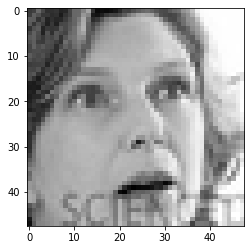

Label: 0,Surprise


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
print(train_features[0].shape)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label},{training_data.classes[label]}")

In [ ]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )

class Net(nn.Module):
    def __init__(self):
        super().__init__()
#         self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3,stride=1,padding=1,bias=False)
        self.layer1=nn.Sequential()
        self.layer1.add_module("l1_Conv1", conv3x3(in_planes=1, out_planes=64, dilation=1))
        self.layer1.add_module("l1_BN1", nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer1.add_module("l1_relu1",nn.ReLU(inplace=True))
        self.layer1.add_module("l1_Conv2", conv3x3(in_planes=64, out_planes=64, dilation=1))
        self.layer1.add_module("l1_BN2", nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer1.add_module("l1_relu2",nn.ReLU(inplace=True))
        self.layer1.add_module("l1_maxPool",nn.MaxPool2d(2, 2))

        self.layer2=nn.Sequential()
        self.layer2.add_module("l2_Conv1", conv3x3(in_planes=64, out_planes=256, dilation=1))
        self.layer2.add_module("l2_BN1", nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer2.add_module("l2_relu1",nn.ReLU(inplace=True))
        self.layer2.add_module("l2_Conv2", conv3x3(in_planes=256, out_planes=256, dilation=1))
        self.layer2.add_module("l2_BN2", nn.BatchNorm2d(num_features=256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer2.add_module("l2_relu2",nn.ReLU(inplace=True))
        self.layer2.add_module("l2_maxPool",nn.MaxPool2d(2, 2))


        self.layer3=nn.Sequential()
        self.layer3.add_module("l3_Conv1", conv3x3(in_planes=256, out_planes=512, dilation=1))
        self.layer3.add_module("l3_BN1", nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer3.add_module("l3_relu1",nn.ReLU(inplace=True))
        self.layer3.add_module("l3_Conv2", conv3x3(in_planes=512, out_planes=512, dilation=1))
        self.layer3.add_module("l3_BN2", nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer3.add_module("l3_relu2",nn.ReLU(inplace=True))
        self.layer3.add_module("l3_Conv3", conv3x3(in_planes=512, out_planes=512, dilation=1))
        self.layer3.add_module("l3_BN3", nn.BatchNorm2d(num_features=512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
        self.layer3.add_module("l3_relu3",nn.ReLU(inplace=True))
        self.layer3.add_module("l3_maxPool",nn.MaxPool2d(2, 2))


        self.fc1 = nn.Linear(512*6*6, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 7)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net=Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 10 == 9:    #
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}')
            running_loss = 0.0

[1,    10] loss: 0.198
[1,    20] loss: 0.000
[1,    30] loss: 0.000
[1,    40] loss: 0.000
[1,    50] loss: 0.000
[1,    60] loss: 0.000
[1,    70] loss: 0.000
[1,    80] loss: 0.000
[1,    90] loss: 0.000
[1,   100] loss: 0.000
[1,   110] loss: 0.000
[1,   120] loss: 0.000
[1,   130] loss: 0.000
[1,   140] loss: 0.000
[1,   150] loss: 0.000
[1,   160] loss: 0.000
[1,   170] loss: 0.000
[1,   180] loss: 0.000
[1,   190] loss: 0.000
[1,   200] loss: 0.000
[1,   210] loss: 0.000
[1,   220] loss: 0.000
[1,   230] loss: 0.000
[1,   240] loss: 0.000
[1,   250] loss: 0.000
[1,   260] loss: 0.000
[1,   270] loss: 0.000
[1,   280] loss: 0.000
[1,   290] loss: 0.000
[1,   300] loss: 0.000
[1,   310] loss: 0.000
[1,   320] loss: 0.000
[1,   330] loss: 0.000
[1,   340] loss: 0.000
[1,   350] loss: 0.000
[1,   360] loss: 0.000
[1,   370] loss: 0.000
[1,   380] loss: 0.000
[1,   390] loss: 0.000
[1,   400] loss: 27.787
[1,   410] loss: 0.011


KeyboardInterrupt: 

tensor([0, 3, 4, 0, 2, 2, 4, 4])
tensor([[  -3.7909,   41.4993,  -16.0410,  -20.2238,   -9.3506,   -7.7345,
          -10.5376],
        [  -3.9793,   42.2535,  -16.3737,  -20.5848,   -9.5547,   -7.8660,
          -10.6190],
        [  -4.3321,   46.6324,  -18.0798,  -22.8084,  -10.6020,   -8.6599,
          -11.7854],
        [  -3.9349,   41.8068,  -16.2012,  -20.3670,   -9.4506,   -7.7805,
          -10.5063],
        [  -3.8823,   41.5143,  -16.0790,  -20.2303,   -9.3694,   -7.7190,
          -10.4497],
        [  -3.9626,   42.1014,  -16.3146,  -20.5104,   -9.5174,   -7.8360,
          -10.5807],
        [ -23.1455,  369.1485, -141.8561, -185.0421,  -75.6300,  -64.0096,
          -99.7308],
        [ -10.4021,  126.4245,  -49.5434,  -63.7598,  -28.2976,  -23.6415,
          -32.0200]], grad_fn=<AddmmBackward>)
['Surprise', 'Fear', 'Angry', 'Neutral', 'Sad', 'Disgust', 'Happy']
Surprise


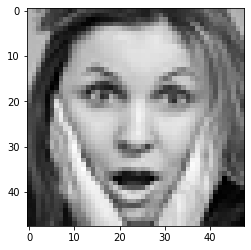

In [ ]:
test_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)

test_features, test_labels = next(iter(test_dataloader))
print(test_labels)

test_detection=net(test_features)
print(test_detection)


img = test_features[0].squeeze()
label = test_labels[0]
print(training_data.classes)
print("{}".format(training_data.classes[label]))
plt.imshow(img, cmap="gray")
plt.show()